In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import math
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import itertools
import warnings
warnings.filterwarnings('ignore')

## Preprocess data

In [4]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [5]:
data = pd.read_excel(PATH)

In [6]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [7]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [8]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [9]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data = maharashtra_data.rename(columns={'Gadchiroli': 'Garhchiroli'})
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

In [ ]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [ ]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [ ]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

## Precipitation data of the district "Pune"

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Pune)

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [ ]:
high_rainfall = {}
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
        high_rainfall[district] = count
high_rainfall

## Boxplot - District wise precipitation across all years

In [ ]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [ ]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [ ]:
m_data_copy.head()

## Monthly rainfall for each year in Maharashtra

In [ ]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

In [ ]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [ ]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

In [ ]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [ ]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

In [ ]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [ ]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").mean()
monthly_mean_data.head()

In [ ]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

In [ ]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))

## Best method for each district

In [ ]:
maharashtra_data.Ahmadnagar.head()

In [ ]:
dates

In [ ]:
rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[:-60]})
rainfall_data.index = dates[:-60]
rainfall_data.tail()

In [ ]:
test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[-60:]})
test_rainfall_data.index = dates[-60:]
test_rainfall_data.head()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rainfall_data)

In [ ]:
import Artificial_Neural_Networks as ANN

In [ ]:
future_steps = 60
STORAGE_FOLDER = 'output/'

parameters_FNN = [[1,2,3,6,8,10,12], [3,4,5,6], [1], [500], [20], [future_steps]]
parameters_FNN = [[12], [4], [1], [500], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,11,12,13], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [300], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6,7,8,9,10], [500], [20], [future_steps]]
parameters_SANN = [[12], [3], [500], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[1,2,3,4,5,6,7,8,9,10,11,12,13], [3,4,5,6], [1], [300], [20], [future_steps]]
parameters_LSTM = [[12], [4], [1], [300], [20], [future_steps]]

In [ ]:
RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, STORAGE_FOLDER)

In [ ]:
ANN.save_RMSE_info(RMSE_info)

In [ ]:
RMSE_info

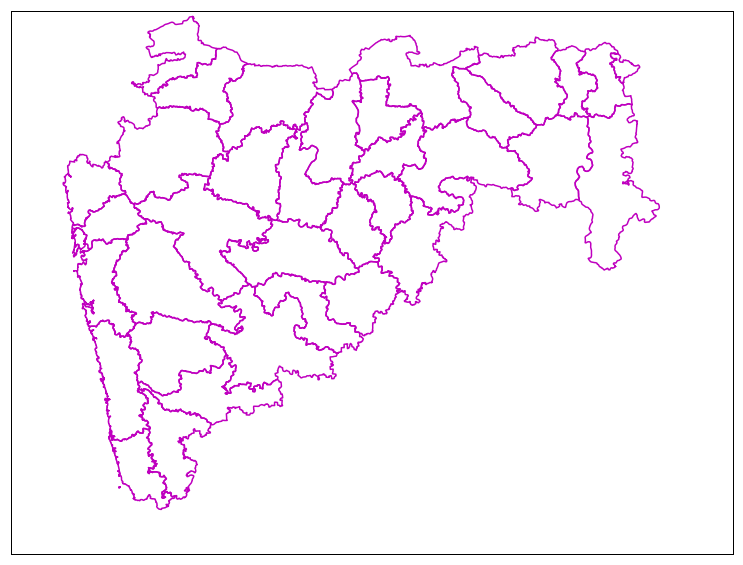

In [11]:
plt.figure(figsize=(15,10))

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
#map.drawcoastlines()

#map.readshapefile('sample_files/comarques', 'comarques')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None,color='m')
plt.show()

In [12]:
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [69]:
maharashtra_data

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193
5,1901-06-01,1901,Jun,262.971,148.203,142.860,171.109,143.611,212.705,164.163,...,268.118,182.832,172.452,411.281,200.694,337.832,154.065,128.469,119.965,104.916
6,1901-07-01,1901,Jul,162.397,236.155,269.763,157.499,237.044,168.635,236.043,...,328.410,151.967,172.251,370.136,295.039,487.674,165.925,228.241,190.457,223.163
7,1901-08-01,1901,Aug,120.152,295.033,282.384,141.114,368.424,154.044,267.994,...,230.975,107.738,210.149,284.110,272.462,405.435,105.419,385.983,321.405,365.451
8,1901-09-01,1901,Sep,58.708,56.731,55.108,58.109,127.879,69.839,74.608,...,65.635,74.486,84.709,127.122,131.615,163.785,65.929,114.336,70.608,121.423
9,1901-10-01,1901,Oct,62.633,119.066,42.729,140.062,3.565,84.208,162.570,...,66.428,45.068,82.933,56.783,76.434,73.775,42.468,29.613,122.672,63.198


In [13]:
year_precipation = pd.DataFrame({'Precipitation': maharashtra_data.ix[0][3:]})
year_precipation.index = maharashtra_data.ix[0].index[3:]
year_precipation.head()

,Precipitation
Ahmadnagar,2.51
Akola,34.202
Amravati,35.651
Aurangabad,10.922
Bhandara,23.397


In [67]:
num_colors = 9
values = year_precipation['Precipitation'].astype(float)
cm = plt.get_cmap('rainbow')
# rainbow, spring, PuRd, plasma
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
year_precipation.sort_values('bin', ascending=False).head()

,Precipitation,bin
Wardha,45.05,8
Amravati,35.651,6
Akola,34.202,6
Hingoli,28.902,5
Parbhani,33.207,5


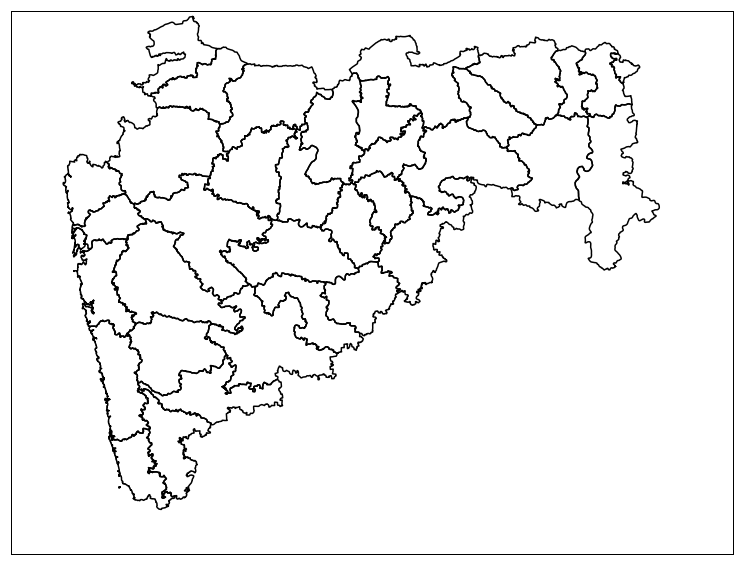

In [61]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
#map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            color = '#ffffff'
            patches = [Polygon(np.array(shape), True)]
            pc = PatchCollection(patches)
            pc.set_facecolor(color)
            ax.add_collection(pc)
    else:
        color = '#dddddd'

plt.show()

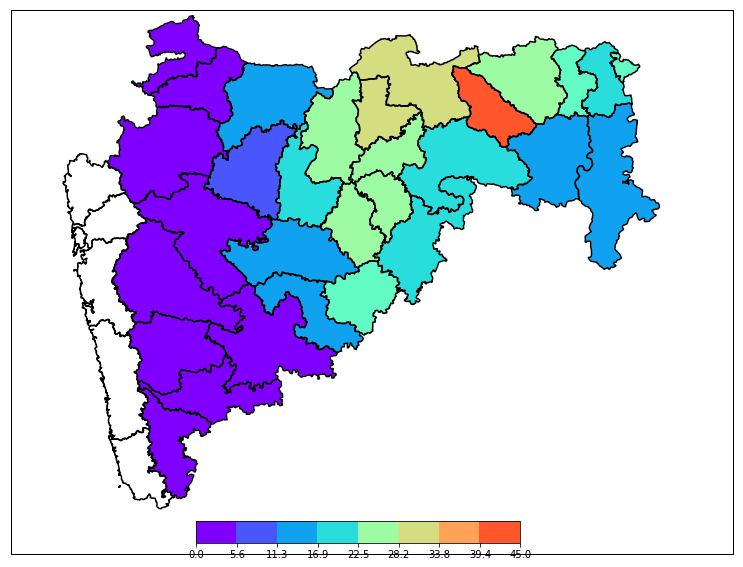

In [68]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
#map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'  

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    
#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()